# **Activity Agent**

The activity agent will be responsible for predicting the user's activity for a given day. It will produce activity probabilities for the given user and the given day on an hourly level. These hourly activity probabilities will be processed by the subsequent recommendation agent to determine for which hours our framework should make recommendations. As input the activity agent receives the prepared data from the preparation agent.

We will define an activity agent class, add necessary functions to the agent, explain each step and build our final activity agent pipeline. A complete activity agent class definition will be available in the appendix to this notebook.

## **1. Preparing the Environment**

### **1.1 Loading the Libraries and the Data**

Steps to set up the environment for the activity agent include loading the necessary libraries, data and preceding agents.


In [1]:
import pandas as pd
import numpy as np

dir = '/Users/sofyakonchakova/Desktop/HU_Berlin/SIS/codes/'
os.chdir(dir)

from helper_functions import Helper
from PreparationAgent import Preparation_Agent
import pandas as pd

helper = Helper()

dbfile  = "/Users/sofyakonchakova/Desktop/home-assistant_Chris.db"


In [2]:
def export_sql2(file = dbfile):
    import sqlite3
    import pandas as pd  
    with sqlite3.connect(file) as con:
        cur = con.cursor()
        cur.execute("SELECT * FROM states")
        states = cur.fetchall()
    from_states_db = []
    for result in states:
        result = list(result)
        from_states_db.append(result)
    columns = ["state_id","entity_id","state","attributes","event_id","last_changed","last_updated","old_state_id","attributes_id","context_id","context_user_id","context_parent_id","origin_idx"]
    states_df = pd.DataFrame(from_states_db, columns = columns)

    with sqlite3.connect(file) as con:
        cur = con.cursor()
        cur.execute("SELECT * FROM state_attributes")
        state_attributes = cur.fetchall()
    from_state_attributes_db = []
    for result in state_attributes:
        result = list(result)
        from_state_attributes_db.append(result)
    columns = ["attributes_id","hash","shared_attributes"]
    state_attributes_df = pd.DataFrame(from_state_attributes_db, columns = columns)

    output = pd.merge(states_df, state_attributes_df, how= "left", on = 'attributes_id')
    return output

In [3]:
# load household data
prep = Preparation_Agent(export_sql2(dbfile))

### **1.2 Calling the Preparation Agent**

To receive the necessary input for the activity agent, we will call the activity pipeline function of the preparation agent. We will specify the input data and the necessary configurations. As a quick validation that the preparation pipeline worked properly, we will plot the hourly activity of the household.

The current input data includes only a few time features and activity lags. However, our agent architecture allows to expand the inputs to the activity agent to further features or further data sources (e.g. whether data). For the purpose of demonstrating the functionality of our framework, we only use the inputs from the prepared REFIT data. 


In [4]:
truncation_params = {
    'features': 'all', 
    'factor': 1.5, 
    'verbose': 1
}

scale_params = {
    'features': 'all', 
    'kind': 'MinMax', 
    'verbose': 1
}

aggregate_params = {
    'resample_param': '60T'
}
#update with active appliances attributes_ids
activity_params = {
    'active_appliances': [573,579,603,605],
    'threshold': .15
}

time_params = {
    'features': ['hour', 'day_name']
}

activity_lag_params = {
    'features': ['activity'],
    'lags': [24, 48, 72]
}

activity_pipe_params = {
    'truncate': truncation_params,
    'scale': scale_params,
    'aggregate': aggregate_params,
    'activity': activity_params,
    'time': time_params,
    'activity_lag': activity_lag_params
}

In [10]:
prep.pipeline_activity

<bound method Preparation_Agent.pipeline_activity of <PreparationAgent.Preparation_Agent object at 0x7fea9597a580>>

In [5]:
# calling the preparation pipelin
db = export_sql2(dbfile)
import pandas as pd
df = prep.pipeline_activity(db, activity_pipe_params)
df

[outlier truncation: 573]: 100%|██████████| 651/651 [00:00<00:00, 540691.47it/s]


[outlier truncation: 573]: 0 outliers were truncated.




[outlier truncation: 579]: 100%|██████████| 302/302 [00:00<00:00, 666673.58it/s]


[outlier truncation: 579]: 0 outliers were truncated.




[outlier truncation: 603]: 0it [00:00, ?it/s]


[outlier truncation: 603]: 0 outliers were truncated.




[outlier truncation: 605]: 0it [00:00, ?it/s]


[outlier truncation: 605]: 0 outliers were truncated.


[MinMaxScaler] Finished scaling the data.


,activity,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
last_updated,,,,,,,,,,,
2022-11-21 17:00:00,1,17,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 18:00:00,1,18,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 19:00:00,0,19,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 20:00:00,1,20,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 21:00:00,0,21,NaN,NaN,NaN,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30 13:00:00,1,13,0.0,0.0,0.0,0,0,0,0,0,1
2022-11-30 14:00:00,1,14,0.0,0.0,0.0,0,0,0,0,0,1
2022-11-30 15:00:00,0,15,0.0,0.0,0.0,0,0,0,0,0,1


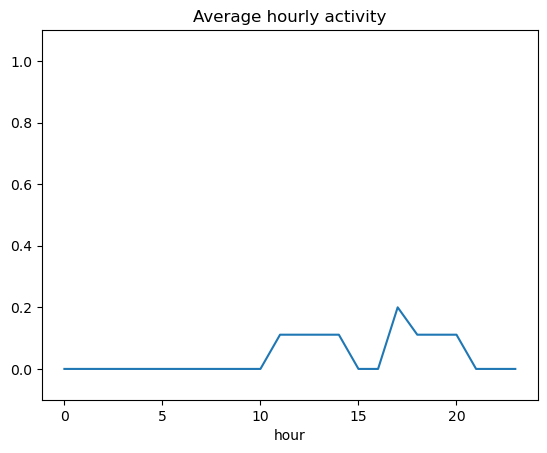

In [6]:
import matplotlib.pyplot as plt

df.groupby(by='hour').mean()['activity'].plot();
plt.title('Average hourly activity')
plt.ylim(-0.1, 1.1);


## **2. Creating the Activity Agent**

In [7]:
class Activity_Agent:

    def __init__(self, activity_input_df):
        self.input = activity_input_df

### **2.1 Train Test Split**

As our recommendation framework will provide recommendations for a given day, our activity agent must be able to provide activity predictions for each day. However, for each day to be predicted we are only allowed to use information from the past to prevent leakage. Therefore, we will create a custom train test split function to meet the time series requirements. 

Our train test split function will enable us to conveniently split our data in the train and test data sets for each day to be predicted while allowing for further configurations of the split (i.e. size of the train and test data sets).

**X_test**

In [8]:
def get_Xtest(self, df, date, time_delta='all', target='activity'):
    import pandas as pd
    from helper_functions import Helper

    helper = Helper()
    
    if time_delta == 'all':
        output = df.loc[pd.to_datetime(date):, df.columns != target]
    else:
        df = helper.get_timespan(df, date, time_delta)
        output = df.loc[:, df.columns != target]
    return output

# add to Activity agent
setattr(Activity_Agent, 'get_Xtest', get_Xtest)
del get_Xtest

In [10]:
date = '2022-11-21'
activity = Activity_Agent(df)
X_test = activity.get_Xtest(df, date)
X_test

,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
last_updated,,,,,,,,,,
2022-11-21 17:00:00,17,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 18:00:00,18,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 19:00:00,19,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 20:00:00,20,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 21:00:00,21,NaN,NaN,NaN,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2022-11-30 13:00:00,13,0.0,0.0,0.0,0,0,0,0,0,1
2022-11-30 14:00:00,14,0.0,0.0,0.0,0,0,0,0,0,1
2022-11-30 15:00:00,15,0.0,0.0,0.0,0,0,0,0,0,1


In [12]:
date = '2022-11-21'
activity = Activity_Agent(df)
time_delta = {'days': 1, 'seconds': -1}
X_test = activity.get_Xtest(df, date, time_delta=time_delta)
X_test

,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
last_updated,,,,,,,,,,
2022-11-21 17:00:00,17,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 18:00:00,18,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 19:00:00,19,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 20:00:00,20,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 21:00:00,21,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 22:00:00,22,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 23:00:00,23,NaN,NaN,NaN,1,0,0,0,0,0


In [13]:
date = '2022-11-21'
activity = Activity_Agent(df)
time_delta = {'days': 7, 'seconds': -1}
X_test = activity.get_Xtest(df, date, time_delta=time_delta)
X_test

,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
last_updated,,,,,,,,,,
2022-11-21 17:00:00,17,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 18:00:00,18,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 19:00:00,19,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 20:00:00,20,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 21:00:00,21,NaN,NaN,NaN,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2022-11-27 19:00:00,19,0.0,0.0,0.0,0,0,1,0,0,0
2022-11-27 20:00:00,20,0.0,0.0,0.0,0,0,1,0,0,0
2022-11-27 21:00:00,21,0.0,0.0,0.0,0,0,1,0,0,0


**y_test**

In [14]:
def get_ytest(self, df, date, time_delta='all', target='activity'):
    import pandas as pd
    from helper_functions import Helper

    helper = Helper()
    
    if time_delta == 'all':
        output = df.loc[pd.to_datetime(date):, target]
    else:
        output = helper.get_timespan(df, date, time_delta)[target]
    return output

# add to Activity agent
setattr(Activity_Agent, 'get_ytest', get_ytest)
del get_ytest

In [15]:
date = '2022-11-21'
activity = Activity_Agent(df)
y_test = activity.get_ytest(df, date)
y_test

last_updated
2022-11-21 17:00:00    1
2022-11-21 18:00:00    1
2022-11-21 19:00:00    0
2022-11-21 20:00:00    1
2022-11-21 21:00:00    0
                      ..
2022-11-30 13:00:00    1
2022-11-30 14:00:00    1
2022-11-30 15:00:00    0
2022-11-30 16:00:00    0
2022-11-30 17:00:00    1
Freq: 60T, Name: activity, Length: 217, dtype: int64

In [22]:
date = '2022-11-22'

activity = Activity_Agent(df)
time_delta = {'days': 7, 'seconds': -1}

y_test = activity.get_ytest(df, date, time_delta=time_delta)
y_test

last_updated
2022-11-22 00:00:00    0
2022-11-22 01:00:00    0
2022-11-22 02:00:00    0
2022-11-22 03:00:00    0
2022-11-22 04:00:00    0
                      ..
2022-11-28 19:00:00    0
2022-11-28 20:00:00    0
2022-11-28 21:00:00    0
2022-11-28 22:00:00    0
2022-11-28 23:00:00    0
Freq: 60T, Name: activity, Length: 168, dtype: int64

**X_train**

In [18]:
# start = int (e.g. -100) --> 100 days before the day to be predicted will represent the train data
def get_Xtrain(self, df, date, start='2013-11-01', target='activity'):
    import pandas as pd

    if type(start) == int:
        start = pd.to_datetime(date) + pd.Timedelta(days= start)
        start = pd.to_datetime('2013-11-01') if start < pd.to_datetime('2013-11-01') else start
    else:
        start = pd.to_datetime(start)
    end = pd.to_datetime(date) + pd.Timedelta(seconds=-1)
    return df.loc[start:end, df.columns != target]

# add to Activity agent
setattr(Activity_Agent, 'get_Xtrain', get_Xtrain)
del get_Xtrain

In [20]:
date = '2022-11-22'

activity = Activity_Agent(df)
X_train = activity.get_Xtrain(df, date)
X_train

,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
last_updated,,,,,,,,,,
2022-11-21 17:00:00,17,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 18:00:00,18,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 19:00:00,19,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 20:00:00,20,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 21:00:00,21,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 22:00:00,22,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 23:00:00,23,NaN,NaN,NaN,1,0,0,0,0,0


In [21]:
date = '2022-11-22'

activity = Activity_Agent(df)
X_train = activity.get_Xtrain(df, date, start=-1)
X_train

,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
last_updated,,,,,,,,,,
2022-11-21 17:00:00,17,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 18:00:00,18,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 19:00:00,19,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 20:00:00,20,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 21:00:00,21,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 22:00:00,22,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 23:00:00,23,NaN,NaN,NaN,1,0,0,0,0,0


In [24]:
date = '2022-11-22'

activity = Activity_Agent(df)
X_train = activity.get_Xtrain(df, date, start=-10)
X_train

,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
last_updated,,,,,,,,,,
2022-11-21 17:00:00,17,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 18:00:00,18,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 19:00:00,19,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 20:00:00,20,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 21:00:00,21,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 22:00:00,22,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 23:00:00,23,NaN,NaN,NaN,1,0,0,0,0,0


In [25]:
date = '2022-11-22'

activity = Activity_Agent(df)
X_train = activity.get_Xtrain(df, date, start=-9999)
X_train

,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
last_updated,,,,,,,,,,
2022-11-21 17:00:00,17,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 18:00:00,18,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 19:00:00,19,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 20:00:00,20,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 21:00:00,21,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 22:00:00,22,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 23:00:00,23,NaN,NaN,NaN,1,0,0,0,0,0


**y_train**

In [31]:
def get_ytrain(self, df, date, start='2022-11-20', target='activity'):
    import pandas as pd

    if type(start) == int:
        start = pd.to_datetime(date) + pd.Timedelta(days= start)
        start = pd.to_datetime('2022-11-20') if start < pd.to_datetime('2022-11-20') else start
    else:
        start = pd.to_datetime(start)
    end = pd.to_datetime(date) + pd.Timedelta(seconds=-1)
    return df.loc[start:end, target]

# add to Activity agent
setattr(Activity_Agent, 'get_ytrain', get_ytrain)
del get_ytrain

In [33]:
date = '2022-11-22'
activity = Activity_Agent(df)
y_train = activity.get_ytrain(df, date)
y_train

last_updated
2022-11-21 17:00:00    1
2022-11-21 18:00:00    1
2022-11-21 19:00:00    0
2022-11-21 20:00:00    1
2022-11-21 21:00:00    0
2022-11-21 22:00:00    0
2022-11-21 23:00:00    0
Freq: 60T, Name: activity, dtype: int64

In [34]:
date = '2022-11-22'
activity = Activity_Agent(df)
y_train = activity.get_ytrain(df, date, start=-1)
y_train

last_updated
2022-11-21 17:00:00    1
2022-11-21 18:00:00    1
2022-11-21 19:00:00    0
2022-11-21 20:00:00    1
2022-11-21 21:00:00    0
2022-11-21 22:00:00    0
2022-11-21 23:00:00    0
Freq: 60T, Name: activity, dtype: int64

In [36]:
date = '2022-11-30'
activity = Activity_Agent(df)
y_train = activity.get_ytrain(df, date, start=-10)
y_train

last_updated
2022-11-21 17:00:00    1
2022-11-21 18:00:00    1
2022-11-21 19:00:00    0
2022-11-21 20:00:00    1
2022-11-21 21:00:00    0
                      ..
2022-11-29 19:00:00    1
2022-11-29 20:00:00    0
2022-11-29 21:00:00    0
2022-11-29 22:00:00    0
2022-11-29 23:00:00    0
Freq: 60T, Name: activity, Length: 199, dtype: int64

In [38]:
date = '2022-11-30'
activity = Activity_Agent(df)
y_train = activity.get_ytrain(df, date, start=-9999)
y_train

last_updated
2022-11-21 17:00:00    1
2022-11-21 18:00:00    1
2022-11-21 19:00:00    0
2022-11-21 20:00:00    1
2022-11-21 21:00:00    0
                      ..
2022-11-29 19:00:00    1
2022-11-29 20:00:00    0
2022-11-29 21:00:00    0
2022-11-29 22:00:00    0
2022-11-29 23:00:00    0
Freq: 60T, Name: activity, Length: 199, dtype: int64

**train_test_split**

<font color = 'red'> Without filling NAs, I cannot procede further. Is it okay? </font>

In [53]:
def train_test_split(self, df, date, train_start='2013-11-01', test_delta='all', target='activity'):
    X_train = self.get_Xtrain(df, date, start=train_start, target=target)
    y_train = self.get_ytrain(df, date, start=train_start, target=target)
    X_test = self.get_Xtest(df, date, time_delta=test_delta, target=target)
    y_test = self.get_ytest(df, date, time_delta=test_delta, target=target)
    X_test = X_test.fillna(0)
    X_train = X_train.fillna(0)
    y_test = y_test.fillna(0)
    y_train = y_train.fillna(0)
    return X_train, y_train, X_test, y_test

# add to Activity agent
setattr(Activity_Agent, 'train_test_split', train_test_split)
del train_test_split    

In [54]:
date = '2022-11-30'
activity = Activity_Agent(df)
X_train, y_train, X_test, y_test = activity.train_test_split(df, date)
df.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((217, 11), (199, 10), (199,), (18, 10), (18,))

In [55]:
date = '2022-11-30'
activity = Activity_Agent(df)
X_train, y_train, X_test, y_test = activity.train_test_split(df, date, train_start=-10, test_delta={'days': 10, 'seconds':-1})
df.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((217, 11), (199, 10), (199,), (18, 10), (18,))

In [56]:
date = '2022-11-30'
activity = Activity_Agent(df)
X_train, y_train, X_test, y_test = activity.train_test_split(df, date, test_delta={'days': 1, 'seconds':-1})
df.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((217, 11), (199, 10), (199,), (18, 10), (18,))

In [57]:
X_train

,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
last_updated,,,,,,,,,,
2022-11-21 17:00:00,17,0.0,0.0,0.0,1,0,0,0,0,0
2022-11-21 18:00:00,18,0.0,0.0,0.0,1,0,0,0,0,0
2022-11-21 19:00:00,19,0.0,0.0,0.0,1,0,0,0,0,0
2022-11-21 20:00:00,20,0.0,0.0,0.0,1,0,0,0,0,0
2022-11-21 21:00:00,21,0.0,0.0,0.0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2022-11-29 19:00:00,19,0.0,0.0,0.0,0,0,0,0,1,0
2022-11-29 20:00:00,20,0.0,0.0,0.0,0,0,0,0,1,0
2022-11-29 21:00:00,21,0.0,0.0,0.0,0,0,0,0,1,0


In [58]:
X_test

,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
last_updated,,,,,,,,,,
2022-11-30 00:00:00,0,0.0,0.0,0.0,0,0,0,0,0,1
2022-11-30 01:00:00,1,0.0,0.0,0.0,0,0,0,0,0,1
2022-11-30 02:00:00,2,0.0,0.0,0.0,0,0,0,0,0,1
2022-11-30 03:00:00,3,0.0,0.0,0.0,0,0,0,0,0,1
2022-11-30 04:00:00,4,0.0,0.0,0.0,0,0,0,0,0,1
2022-11-30 05:00:00,5,0.0,0.0,0.0,0,0,0,0,0,1
2022-11-30 06:00:00,6,0.0,0.0,0.0,0,0,0,0,0,1
2022-11-30 07:00:00,7,0.0,0.0,0.0,0,0,0,0,0,1
2022-11-30 08:00:00,8,0.0,0.0,0.0,0,0,0,0,0,1


In [59]:
y_train

last_updated
2022-11-21 17:00:00    1
2022-11-21 18:00:00    1
2022-11-21 19:00:00    0
2022-11-21 20:00:00    1
2022-11-21 21:00:00    0
                      ..
2022-11-29 19:00:00    1
2022-11-29 20:00:00    0
2022-11-29 21:00:00    0
2022-11-29 22:00:00    0
2022-11-29 23:00:00    0
Freq: 60T, Name: activity, Length: 199, dtype: int64

In [60]:
y_test

last_updated
2022-11-30 00:00:00    0
2022-11-30 01:00:00    0
2022-11-30 02:00:00    0
2022-11-30 03:00:00    0
2022-11-30 04:00:00    0
2022-11-30 05:00:00    0
2022-11-30 06:00:00    0
2022-11-30 07:00:00    0
2022-11-30 08:00:00    0
2022-11-30 09:00:00    0
2022-11-30 10:00:00    0
2022-11-30 11:00:00    1
2022-11-30 12:00:00    1
2022-11-30 13:00:00    1
2022-11-30 14:00:00    1
2022-11-30 15:00:00    0
2022-11-30 16:00:00    0
2022-11-30 17:00:00    1
Freq: 60T, Name: activity, dtype: int64

### **2.2 Building Models**

Within this section, we will demonstrate how different models for predicting the user activity could be added to the activity agent. For this notebook, we chose to implement a pretty simple logistic regression using the statsmodel api which already provides promising results. 

The functionality of the activity agent will include building models, fitting models and predicting the user’s activity.


In [61]:
def fit_smLogit(self, X, y):
    import statsmodels.api as sm
    return sm.Logit(y, X).fit(disp=False)

# add to Activity agent
setattr(Activity_Agent, 'fit_smLogit', fit_smLogit)
del fit_smLogit 

In [62]:
def fit(self, X, y, model_type):
    if model_type == 'logit':
        model = self.fit_smLogit(X, y)
    else:
        raise InputError('Unknown model type.')
    return model

# add to Activity agent
setattr(Activity_Agent, 'fit', fit)
del fit

In [63]:
activity = Activity_Agent(df)
model = activity.fit(X_train, y_train, 'logit')
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:               activity   No. Observations:                  199
Model:                          Logit   Df Residuals:                      189
Method:                           MLE   Df Model:                            9
Date:                Mon, 12 Dec 2022   Pseudo R-squ.:                 -0.2966
Time:                        23:07:03   Log-Likelihood:                -25.397
converged:                      False   LL-Null:                       -19.588
Covariance Type:            nonrobust   LLR p-value:                     1.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
hour                  -0.1165      0.041     -2.862      0.004      -0.196      -0.037
activity_lag_24      -18.5990   7.34e+04     -0.000      1.000   -1.44e+05    1.44e+05
activity_lag_48     

/Users/sofyakonchakova/Conda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [64]:
def predict(self, model, X):
    import statsmodels

    if type(model) == statsmodels.discrete.discrete_model.BinaryResultsWrapper:
        y_hat = model.predict(X)
    else:
        raise InputError('Unknown model type.')
    return y_hat

# add to Activity agent
setattr(Activity_Agent, 'predict', predict)
del predict

In [65]:
activity = Activity_Agent(df)
y_hat = activity.predict(model, X_test)
y_hat

last_updated
2022-11-30 00:00:00    2.413900e-28
2022-11-30 01:00:00    2.148427e-28
2022-11-30 02:00:00    1.912150e-28
2022-11-30 03:00:00    1.701858e-28
2022-11-30 04:00:00    1.514694e-28
2022-11-30 05:00:00    1.348113e-28
2022-11-30 06:00:00    1.199852e-28
2022-11-30 07:00:00    1.067896e-28
2022-11-30 08:00:00    9.504526e-29
2022-11-30 09:00:00    8.459250e-29
2022-11-30 10:00:00    7.528930e-29
2022-11-30 11:00:00    6.700923e-29
2022-11-30 12:00:00    5.963978e-29
2022-11-30 13:00:00    5.308080e-29
2022-11-30 14:00:00    4.724315e-29
2022-11-30 15:00:00    4.204751e-29
2022-11-30 16:00:00    3.742326e-29
2022-11-30 17:00:00    3.330758e-29
Freq: 60T, dtype: float64

### **2.3 Model Evaluation**

A drawback to our approach is that we are not able to apply conventional model evaluation techniques to our model. We will train our model for each day to account for newly available information. Hence, we have different train and test sets for each day and for each day different performance metric based on the respective data sets. Therefore, we created our own evaluation function. 

Our evaluation function will build a model, fit the model and predict the target for each day for a given prediction period. For each day and fitted model it will calculate a performance metric on the train data. We chose the Area Under the Receiver Operating Characteristic Curve (AUC) as performance metric for our binary classification task. As in our case the test data is only the current date to be predicted (i.e. 24 data cases in the test data, one for each hour of the day), calculating the AUC on the test date immediately would lead to a high volatility in the test AUC per day to be predicted. Therefore, we calculate the test AUC over the activity probabilities of all days after all days have been predicted. To summarize the train AUC in one score, we apply an average over all calculated train AUC scores.

In [66]:
def auc(self, y_true, y_hat):
    import sklearn.metrics
    return sklearn.metrics.roc_auc_score(y_true, y_hat)

# add to Activity agent
setattr(Activity_Agent, 'auc', auc)
del auc

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 217 entries, 2022-11-21 17:00:00 to 2022-11-30 17:00:00
Freq: 60T
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   activity            217 non-null    int64  
 1   hour                217 non-null    int64  
 2   activity_lag_24     193 non-null    float64
 3   activity_lag_48     169 non-null    float64
 4   activity_lag_72     145 non-null    float64
 5   day_name_Monday     217 non-null    uint8  
 6   day_name_Saturday   217 non-null    uint8  
 7   day_name_Sunday     217 non-null    uint8  
 8   day_name_Thursday   217 non-null    uint8  
 9   day_name_Tuesday    217 non-null    uint8  
 10  day_name_Wednesday  217 non-null    uint8  
dtypes: float64(3), int64(2), uint8(6)
memory usage: 19.5 KB


In [83]:
dates = pd.DataFrame(df.index).set_index(df.index)['last_updated'].apply(lambda date: str(date)[:10]).drop_duplicates()

In [84]:
dates

last_updated
2022-11-21 17:00:00    2022-11-21
2022-11-22 00:00:00    2022-11-22
2022-11-23 00:00:00    2022-11-23
2022-11-24 00:00:00    2022-11-24
2022-11-25 00:00:00    2022-11-25
2022-11-26 00:00:00    2022-11-26
2022-11-27 00:00:00    2022-11-27
2022-11-28 00:00:00    2022-11-28
2022-11-29 00:00:00    2022-11-29
2022-11-30 00:00:00    2022-11-30
Name: last_updated, dtype: object

<font color = 'red'> Does not work. Dates are messed up? Failed to converge Maximum Likelihood. </font >

In [105]:
def evaluate(self, df, model_type, split_params, predict_start='2022-11-30', predict_end=-1):
    import pandas as pd
    import numpy as np
    from tqdm import tqdm

    dates = pd.DataFrame(df.index).set_index(df.index)['last_updated'].apply(lambda date: str(date)[:10]).drop_duplicates()

    predict_start = pd.to_datetime(predict_start)
    predict_end = pd.to_datetime(dates[predict_end]) if type(predict_end) == int else pd.to_datetime(predict_end)

    dates = dates.loc[predict_start:predict_end]
    
    y_true = []
    y_hat_train = {}
    y_hat_test = []
    auc_train_dict = {}
    auc_test = []

    for date in tqdm(dates):
        # train test split
        #train_test_split(self, df, date, train_start='2013-11-01', test_delta='all', target='activity')
        X_train, y_train, X_test, y_test = self.train_test_split(df, date, **split_params)

        # fit model
        model = self.fit(X_train, y_train, model_type)

        # predict
        y_hat_train.update({date: self.predict(model, X_train)})
        y_hat_test += list(self.predict(model, X_test))

        # evaluate train data
        auc_train_dict.update({date: self.auc(y_train, list(y_hat_train.values())[-1])})
        
        y_true += list(y_test)
    
    auc_test = self.auc(y_true, y_hat_test)
    auc_train = np.mean(list(auc_train_dict.values()))

    return auc_train, auc_test, auc_train_dict


# add to Activity agent
setattr(Activity_Agent, 'evaluate', evaluate)
del evaluate

In [106]:
split_params = {'train_start': '2022-11-22', 'test_delta': {'days':1, 'seconds':-1}, 'target': 'activity'}
activity = Activity_Agent(df)
auc_train, auc_test, auc_train_dict = activity.evaluate(df, 'logit', split_params) 

  0%|          | 0/1 [00:00<?, ?it/s]/Users/sofyakonchakova/Conda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
100%|██████████| 1/1 [00:00<00:00, 33.97it/s]


In [107]:
# printing the scores
print(f'[model performance] train auc score: {auc_train}\n[model performance] test auc score: {auc_test}')

[model performance] train auc score: 0.6832460732984293
[model performance] test auc score: 0.12307692307692308


### **2.4 Pipeline Function**

The pipeline function of the activity agent will receive a date as input, create the appropriate train test split, fit the selected model to the data and return the activity predictions for the day to be predicted. The subsequent recommendation agent will process these activity probabilities to provide recommendations to the user.

In [108]:
def pipeline(self, df, date, model_type, split_params):
    X_train, y_train, X_test, y_test = self.train_test_split(df, date, **split_params)

    # fit model
    model = self.fit(X_train, y_train, model_type)

    # predict
    return self.predict(model, X_test)

# add to Activity agent
setattr(Activity_Agent, 'pipeline', pipeline)
del pipeline

In [123]:
activity = Activity_Agent(df)

date = '2022-12-01'
split_params = {'train_start': '2022-11-22', 'test_delta': {'days':1, 'seconds':-1}, 'target': 'activity'}

output = activity.pipeline(df, date, 'logit', split_params)
output

/Users/sofyakonchakova/Conda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Series([], Freq: 60T, dtype: float64)

IndexError: index 0 is out of bounds for axis 0 with size 0

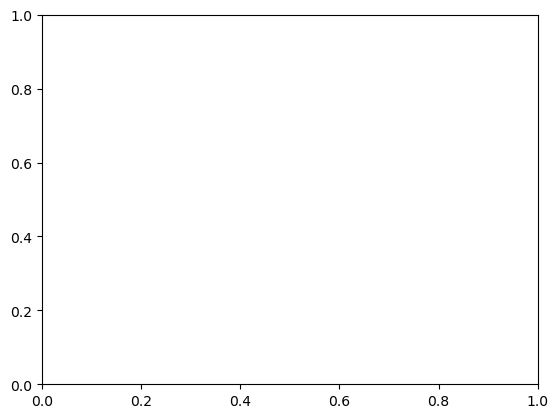

In [118]:
output.plot();
plt.ylim(-.1, 1.1);

## **Appendix A1: Complete Activity Agent Class**

In [45]:
class Activity_Agent:
    def __init__(self, activity_input_df):
        self.input = activity_input_df

    # train test split
        # -------------------------------------------------------------------------------------------
    def get_Xtest(self, df, date, time_delta='all', target='activity'):
        import pandas as pd
        from helper_functions import Helper

        helper = Helper()
        
        if time_delta == 'all':
            output = df.loc[pd.to_datetime(date):, df.columns != target]
        else:
            df = helper.get_timespan(df, date, time_delta)
            output = df.loc[:, df.columns != target]
        return output

    def get_ytest(self, df, date, time_delta='all', target='activity'):
        import pandas as pd
        from helper_functions import Helper

        helper = Helper()
        
        if time_delta == 'all':
            output = df.loc[pd.to_datetime(date):, target]
        else:
            output = helper.get_timespan(df, date, time_delta)[target]
        return output

    def get_Xtrain(self, df, date, start='2013-11-01', target='activity'):
        import pandas as pd

        if type(start) == int:
            start = pd.to_datetime(date) + pd.Timedelta(days= start)
            start = pd.to_datetime('2013-11-01') if start < pd.to_datetime('2013-11-01') else start
        else:
            start = pd.to_datetime(start)
        end = pd.to_datetime(date) + pd.Timedelta(seconds=-1)
        return df.loc[start:end, df.columns != target]

    def get_ytrain(self, df, date, start='2022-11-20', target='activity'):
        import pandas as pd

        if type(start) == int:
            start = pd.to_datetime(date) + pd.Timedelta(days= start)
            start = pd.to_datetime('2022-11-20') if start < pd.to_datetime('2022-11-20') else start
        else:
            start = pd.to_datetime(start)
        end = pd.to_datetime(date) + pd.Timedelta(seconds=-1)
        return df.loc[start:end, target]

    def train_test_split(self, df, date, train_start='2013-11-01', test_delta='all', target='activity'):
        X_train = self.get_Xtrain(df, date, start=train_start, target=target)
        y_train = self.get_ytrain(df, date, start=train_start, target=target)
        X_test = self.get_Xtest(df, date, time_delta=test_delta, target=target)
        y_test = self.get_ytest(df, date, time_delta=test_delta, target=target)
        X_test = X_test.fillna(0)
        X_train = X_train.fillna(0)
        y_test = y_test.fillna(0)
        y_train = y_train.fillna(0)
        return X_train, y_train, X_test, y_test


    # model training and evaluation
    # -------------------------------------------------------------------------------------------
    def fit_smLogit(self, X, y):
        import statsmodels.api as sm
        return sm.Logit(y, X).fit(disp=False)

    def fit(self, X, y, model_type):
        if model_type == 'logit':
            model = self.fit_smLogit(X, y)
        else:
            raise InputError('Unknown model type.')
        return model

    def predict(self, model, X):
        import statsmodels

        if type(model) == statsmodels.discrete.discrete_model.BinaryResultsWrapper:
            y_hat = model.predict(X)
        else:
            raise InputError('Unknown model type.')
        return y_hat

    def auc(self, y_true, y_hat):
        import sklearn.metrics
        return sklearn.metrics.roc_auc_score(y_true, y_hat)

    def evaluate(self, df, model_type, split_params, predict_start='2022-11-30', predict_end=-1):
        import pandas as pd
        import numpy as np
        from tqdm import tqdm

        dates = pd.DataFrame(df.index).set_index(df.index)['last_updated'].apply(lambda date: str(date)[:10]).drop_duplicates()

        predict_start = pd.to_datetime(predict_start)
        predict_end = pd.to_datetime(dates[predict_end]) if type(predict_end) == int else pd.to_datetime(predict_end)

        dates = dates.loc[predict_start:predict_end]
        
        y_true = []
        y_hat_train = {}
        y_hat_test = []
        auc_train_dict = {}
        auc_test = []

        for date in tqdm(dates):
            # train test split
            #train_test_split(self, df, date, train_start='2013-11-01', test_delta='all', target='activity')
            X_train, y_train, X_test, y_test = self.train_test_split(df, date, **split_params)

            # fit model
            model = self.fit(X_train, y_train, model_type)

            # predict
            y_hat_train.update({date: self.predict(model, X_train)})
            y_hat_test += list(self.predict(model, X_test))

            # evaluate train data
            auc_train_dict.update({date: self.auc(y_train, list(y_hat_train.values())[-1])})
            
            y_true += list(y_test)
        
        auc_test = self.auc(y_true, y_hat_test)
        auc_train = np.mean(list(auc_train_dict.values()))

        return auc_train, auc_test, auc_train_dict


    # pipeline function: predicting user activity
    # -------------------------------------------------------------------------------------------
    def pipeline(self, df, date, model_type, split_params):
        # train test split
        X_train, y_train, X_test, y_test = self.train_test_split(
            df, date, **split_params
        )

        # fit model
        model = self.fit(X_train, y_train, model_type)

        # predict
        return self.predict(model, X_test)